In [31]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.info import getinfo
#import sigpy.mri as mr
from Utils.GenMask import gen_mask
from Utils.Transform_torch import  inverse_fourier_transform_numpy
from Utils.Transform_tensor_torch import fourier_transform
import torch
from Utils.Normalize_complex_data import normalize_complex_data

## **Simulation of the data undersampling**

In [32]:
kspace, image = getinfo()
image = image[22]
ksp = kspace[22]
Cs = np.load('./Data/sensitivities_normalized_cs.npy') # Mask with 186 lines and 0 central lines.
Cs_2 = np.load('./Data/sensitivities_normalized_cs_2.npy') # Mask with 156 lines and 30 central lines.
mask = gen_mask(ksp,num_lines=186, num_central_lines=0)
mask_2 = gen_mask(ksp,num_lines=156, num_central_lines=30)
s = ksp * mask 
s_2 = ksp * mask_2

In [33]:
s_normalized = normalize_complex_data(s)
s_2_normalized = normalize_complex_data(s_2)
x_normalized = inverse_fourier_transform_numpy(s_normalized)
x_2_normalized = inverse_fourier_transform_numpy(s_2_normalized)

print("Max of |s_normalized|:", np.max(np.abs(s_normalized)))
print("Max of |sensitivities_normalized_cs| (coil normalization per sensitivities_normalized_cs):", np.max(np.sum(np.abs(Cs) ** 2, axis=0)))
print("Max of |sensitivities_normalized_ksp| (coil normalization per sensitivities_normalized_ksp):", np.max(np.sum(np.abs(Cs_2) ** 2, axis=0)))

Max of |s_normalized|: 1.0
Max of |sensitivities_normalized_cs| (coil normalization per sensitivities_normalized_cs): 1.0000005
Max of |sensitivities_normalized_ksp| (coil normalization per sensitivities_normalized_ksp): 1.0000005


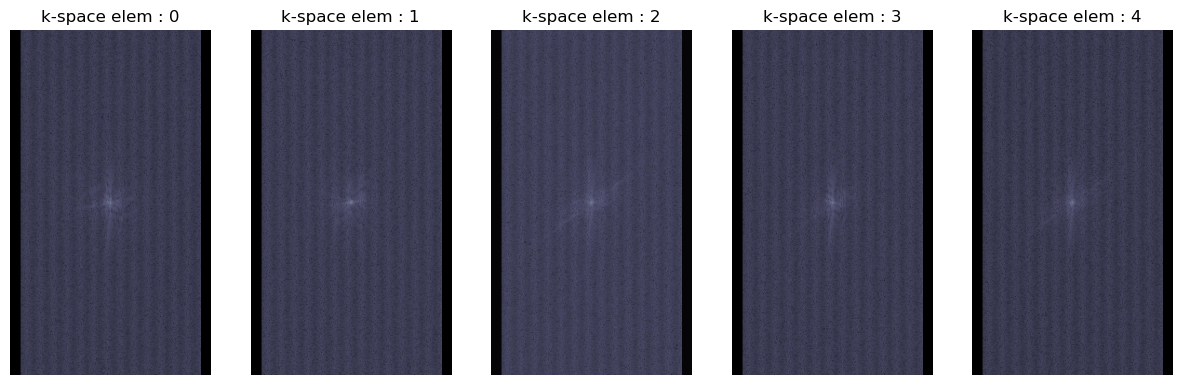

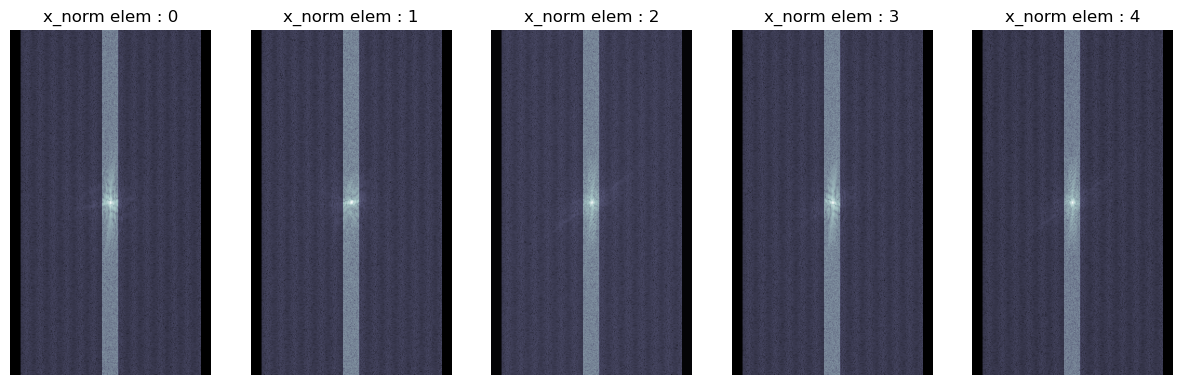

In [34]:
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.log(np.abs(s_normalized[i]) + 1e-12), cmap='bone')
    plt.title(f'k-space elem : {i}')
    plt.axis('off')
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.log(np.abs(s_2_normalized[i]) + 1e-12), cmap='bone')
    plt.title(f'x_norm elem : {i}')
    plt.axis('off')

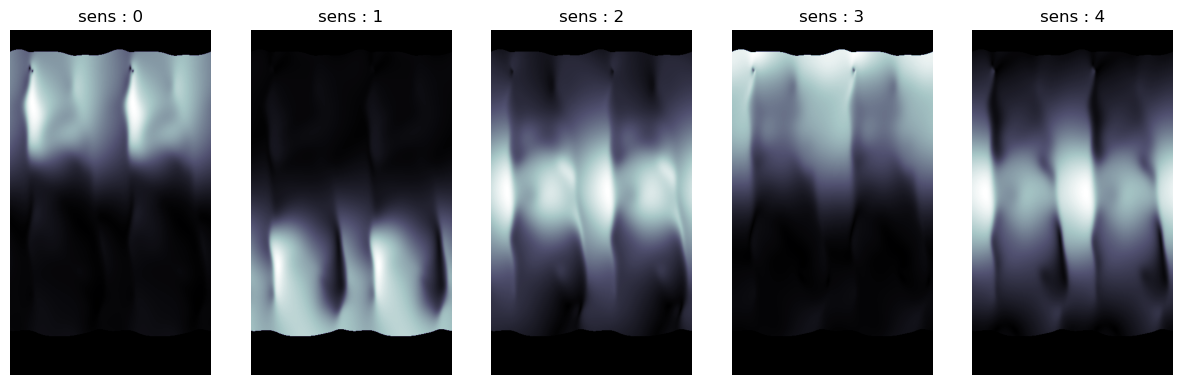

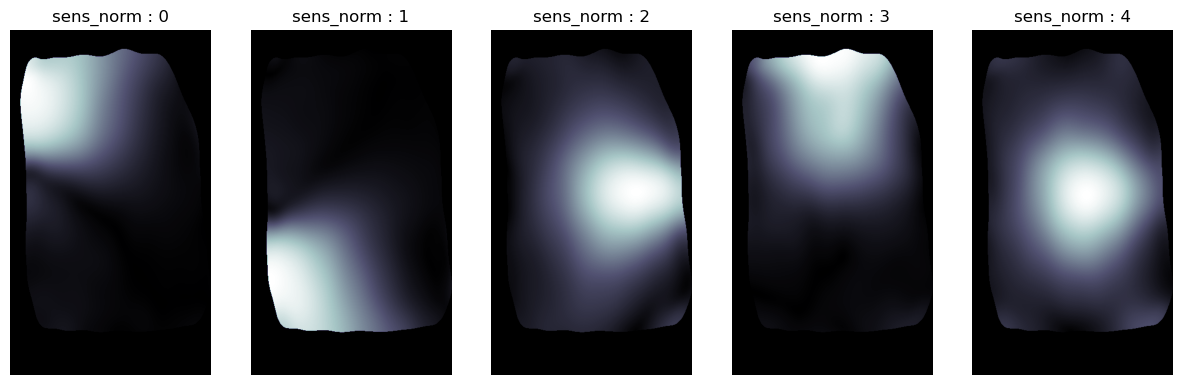

In [35]:
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(Cs[i]), cmap='bone')
    plt.title(f'sens : {i}')
    plt.axis('off')
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(Cs_2[i]), cmap='bone')
    plt.title(f'sens_norm : {i}')
    plt.axis('off')

In [36]:
def loss(x, s, mask, Cs, lmda=0.1):
    
    # Step 1: Compute E(x)
    C_x = x * Cs
    CF_x = fourier_transform(C_x)
    E_x = mask * CF_x

    # Step 2: Compute loss: 1/2 * ||s - E(x)||^2 + lambda * ||x||^2
    data_fidelity = torch.sum(torch.abs(s - E_x) ** 2) / 2
    regularization = lmda * torch.sum(torch.abs(x) ** 2)
    total_loss = data_fidelity + regularization

    return total_loss

def GD(s, mask, Cs, lr=0.01, epochs=10, lmda=0.1):
    
    # Move other variables to the same device (GPU or CPU)
    s = torch.tensor(s, dtype=torch.complex128, device='cuda')
    mask = torch.tensor(mask, dtype=torch.complex128, device='cuda')
    Cs = torch.tensor(Cs, dtype=torch.complex128, device='cuda')
    
    # Initialize x as a complex matrix in PyTorch within a small range
    x = torch.randn_like(torch.zeros(s.shape, dtype=torch.complex128, device='cuda')) * 0.01
    x.requires_grad = True 

    lista_loss = []
    for i in range(epochs):
        
        # Compute loss
        losses = loss(x, s, mask, Cs, lmda)

        # Compute gradients using backward() for the loss
        losses.backward()

        # Update x using the gradient
        with torch.no_grad():
            x -= lr * x.grad 

        # Zero the gradients after the update
        x.grad.zero_()

        # Store the loss
        lista_loss.append(losses.item())

        # Print loss
        if i % 100 == 0:
            plt.imshow(torch.log(torch.abs(x[5])+1e-4).cpu().detach().numpy(), cmap='bone')
            plt.title(f'Epoch {i} - Loss: {losses.item()}')
            plt.show()

    return x, lista_loss

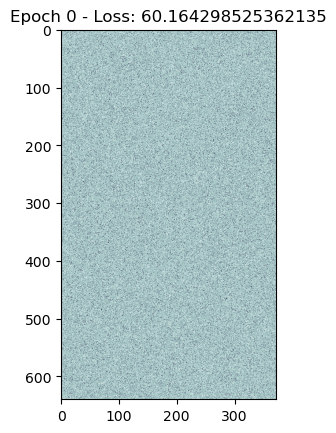

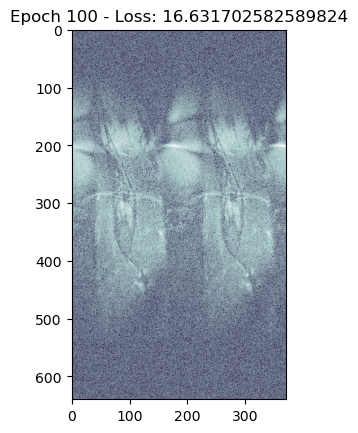

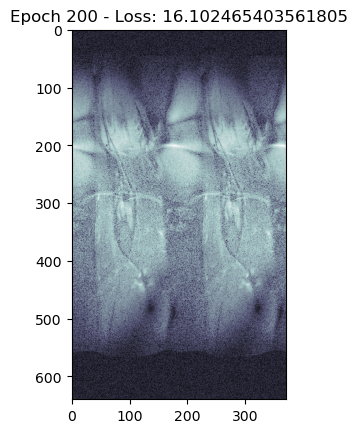

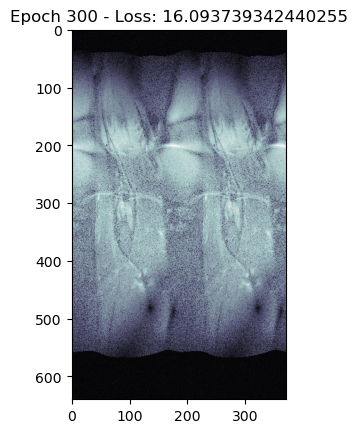

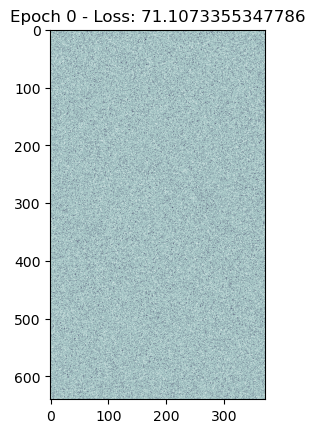

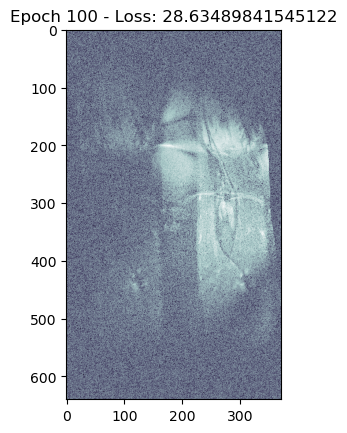

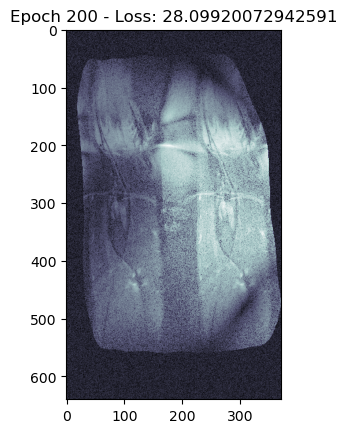

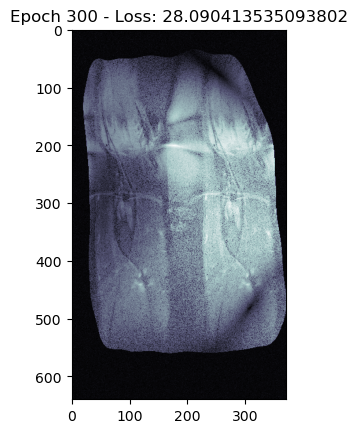

In [37]:
# Run gradient descent
x_final_cs, loss_history_cs = GD(s_normalized, mask, Cs, lr=0.1, epochs=400, lmda=0.1)
x_final_cs_2, loss_history_cs_2 = GD(s_2_normalized, mask, Cs_2, lr=0.1, epochs=400, lmda=0.1)

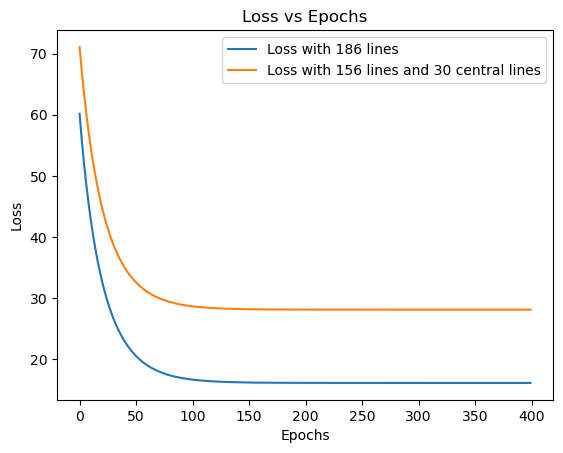

In [38]:
plt.plot(loss_history_cs, label='Loss with 186 lines')
plt.plot(loss_history_cs_2, label='Loss with 156 lines and 30 central lines')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

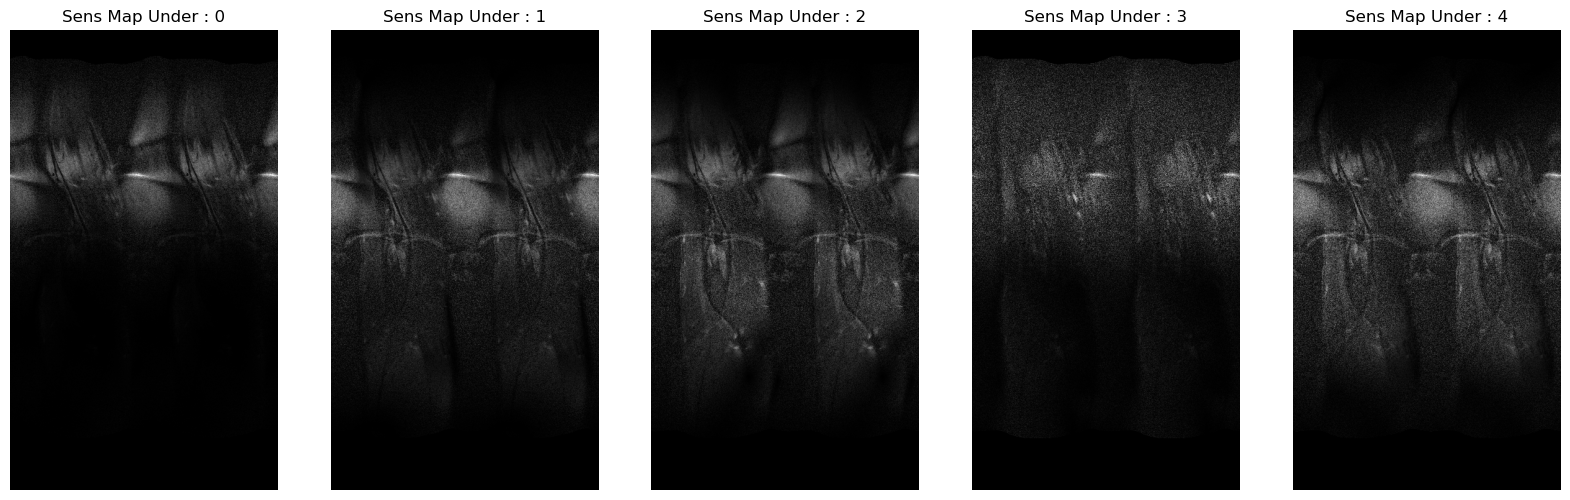

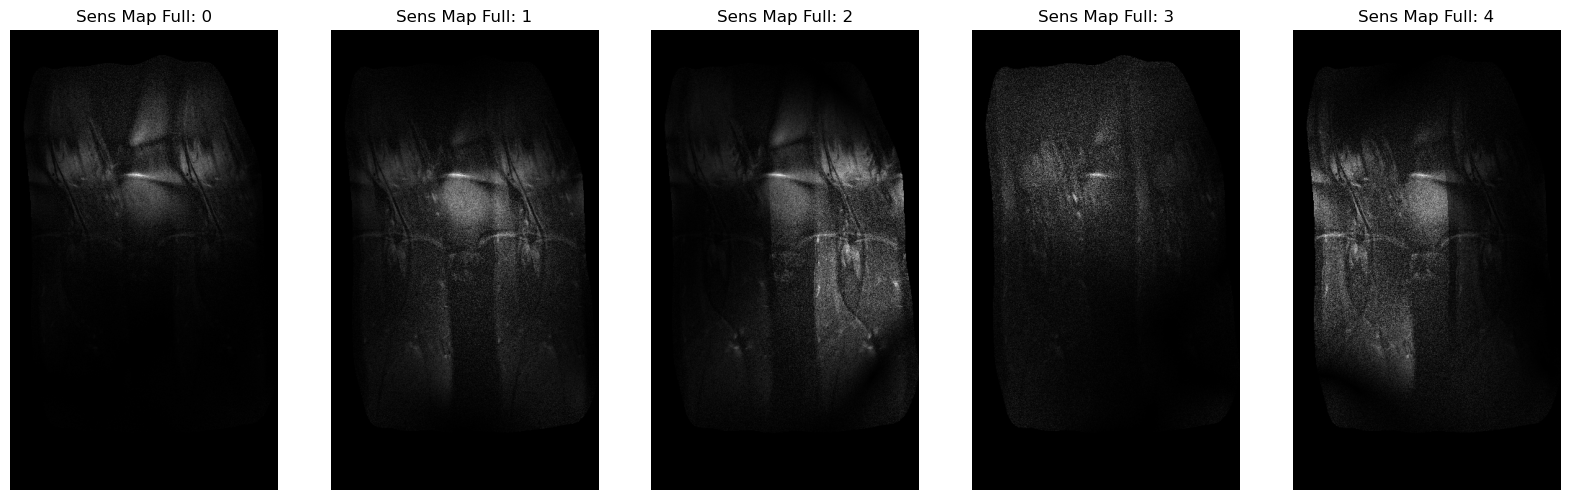

In [39]:
X_cs = x_final_cs.cpu().detach().numpy()
X_cs_2 = x_final_cs_2.cpu().detach().numpy()
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(X_cs[i+3]), cmap='gray')
    plt.title(f'Sens Map Under : {i}')
    plt.axis('off')
    
plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.abs(X_cs_2[i+3]), cmap='gray')
    plt.title(f'Sens Map Full: {i}')
    plt.axis('off')

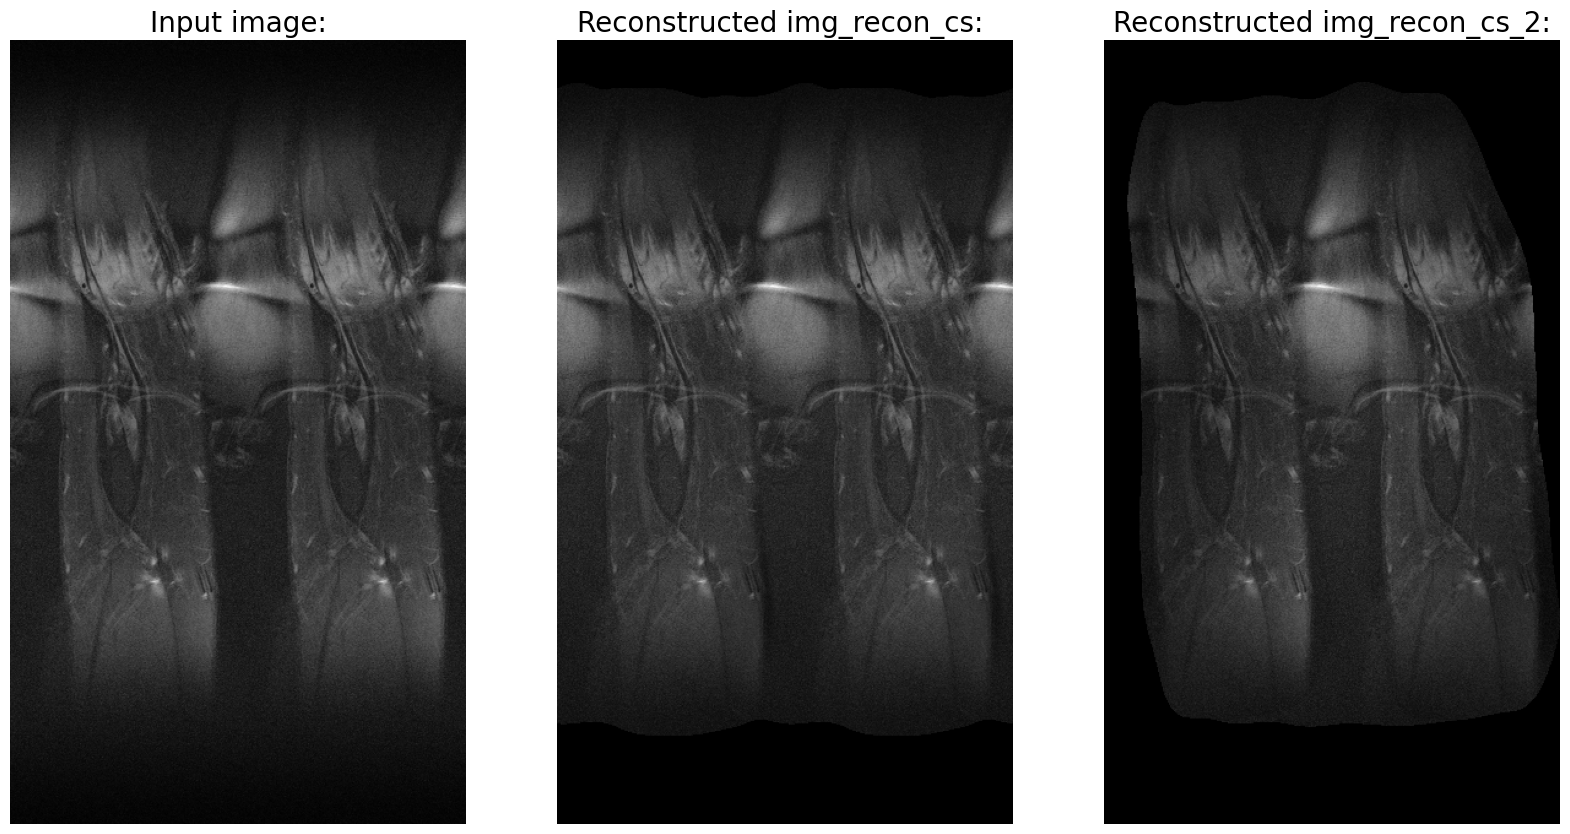

In [40]:
img_recon_cs_1 = np.sum(np.abs(X_cs), axis=0)
np.save('./Data/img_recon_cs.npy', img_recon_cs_1)
img_recon_cs_2 = np.sum(np.abs(X_cs_2), axis=0)
np.save('./Data/img_recon_cs_2.npy', img_recon_cs_2)

img_input = inverse_fourier_transform_numpy(s_normalized)
img_input = np.sum(np.abs(img_input), axis=0)

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(np.log(img_input + 1e-1), cmap='gray')
plt.axis('off')
plt.title(f'Input image:', fontsize=20)
plt.subplot(1, 3, 2)
plt.imshow(np.log(img_recon_cs_1 + 1e-1), cmap='gray')
plt.axis('off')
plt.title(f'Reconstructed img_recon_cs: ', fontsize=20)
plt.subplot(1, 3, 3)
plt.imshow(np.log(img_recon_cs_2 + 1e-1), cmap='gray')
plt.axis('off')
plt.title(f'Reconstructed img_recon_cs_2:', fontsize=20)
plt.show()